# Projeto de Filtros
Curso: ENGC63 - Processamento Digital de Sinais
- Ivon Luiz
- Heverton

<b>Filtros</b> são sistemas que selecionam ou modificam certas frequências de um sinal de entrada. Eles podem ser seletivos em frequência, passando apenas certas frequências e rejeitando outras, ou podem modificar frequências de maneira mais geral.

O projeto de filtros de tempo discreto envolve determinar os parâmetros de uma <b>função de transferência</b> ou <b>equação de diferenças</b> que aproxima uma resposta ao impulso ou em frequência dentro de tolerâncias especificadas. Existem duas categorias principais: <b>filtros com resposta ao impulso infinita (IIR)</b> e <b>filtros com resposta ao impulso finita (FIR)</b>. O projeto de filtros IIR envolve obter uma função de transferência racional, enquanto o projeto de filtros FIR resulta em uma aproximação polinomial. As técnicas de projeto para essas duas classes são diferentes.

O seguinte relatório demonstra a implementação de um <b>filtro passa-baixas FIR</b> utilizando o <b>método de janelamento</b>, mais especificamente a <b>janela de Kaiser</b>.  

## Bibliotecas

In [30]:
import numpy as np
from numpy import pi, sinc, arange, log10
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import signal
from scipy.signal import firwin, kaiserord, freqz, tf2sos, sosfreqz, tf2zpk
from scipy.signal.windows import kaiser
from utils import plot_zeros, plot_impulse_response, plot_frequency_response, plot_approximation_error, plot_phase_response, plot_group_delay, plot_frequency_and_phase_response

## Método de Janelamento

Muitos sistemas idealizados têm respostas em frequência que são constantes ou suaves por partes, com descontinuidades nas extremidades. Isso resulta em respostas ao impulso que são não causais e infinitamente longas. Para aproximar esses sistemas com <b>filtros FIR</b>, o método mais direto é *truncar* a resposta ao impulso ideal usando o <b>processo de janelamento</b>.

Considera-se um <b>filtro passa-baixas ideal</b> com fase linear do tipo:

$$
H_d(e^{j\omega}) = 
\begin{cases} 
e^{-j\omega n_d}, & |ω| ≤ ω_c \\
0, & ω_c < |ω| ≤ π 
\end{cases}
$$

Tal sistema possui a seguinte resposta ao impulso:

$$
h_d[n] = \frac{\sin(ω_c(n − n_d))}{π(n − n_d)}, \quad -∞ < n < ∞
$$

Verifica-se que a resposta ao impulso possui <b>duração infinita</b> e é <b>não causal</b>. Uma maneira mais usual de obter um filtro FIR causal a partir de $h_d[n]$ consiste em *truncar* $h_d[n]$, isto é, definir um novo sistema com resposta ao impulso $h[n]$ dada por:

$$
h[n] =
\begin{cases} 
h_d[n], & 0 ≤ n ≤ M \\
0, & caso\;contrário 
\end{cases}
$$

Isto é equivalente a multiplicar a resposta ao impulso tideal $h_d[n]$ por uma janela de duração finita $w[n]$:

$$
h[n] = h_d[n] · w[n]
$$

E, tem-se que, $w[n]$ representa uma <b>janela retangular</b> para um truncamento simples:

$$
w[n] =
\begin{cases} 
1, & 0 ≤ n ≤ M
0, & caso\;contrário 
\end{cases}
$$

Assim, pelo teorema da modulação:

$$
H(e^{j\omega}) = \frac{1}{2\pi}\int_{-\pi}^{\pi} H_d(e^{j\theta})W(e^{j(\omega-\theta)}) \,d\theta
$$

onde $H(e^{j\omega})$ é a convolução periódica da resposta ideal desejada $H_d(e^{j\omega})$ com a <b>transformada de Fourier</b> da janela. Isso faz com que $H(e^{j\omega})$ seja uma versão “espalhada” de $H_d(e^{j\omega})$. Se não houver truncamento (ou seja, $w[n] = 1$ para todo $n$), $W(e^{j\omega})$ será um trem de impulsos periódico, e $H(e^{j\omega}) = H_d(e^{j\omega})$.

Para que $H(e^{j\omega})$ se aproxime de $H_d(e^{j\omega})$, a janela $w[n]$ deve ser escolhida de modo que $W(e^{j\omega})$ esteja concentrado em uma faixa estreita de frequências em torno de $\omega = 0$. Isso minimiza os cálculos e garante que a convolução reproduza fielmente a resposta em frequência desejada.


### Janela de Kaiser

A janela de Kaiser é um método simples que foi desenvolvida por Kaiser em 1974. Ela veio para evitar a metodologia de se testar diferentes janelas e ajustar comprimentos por tentativa e erro para projetar filtros.
 
A janela de Kaiser é definida como:

$$
w[n] = 
\begin{cases} 
\frac{I_0\left(\beta \sqrt{1 - \left(\frac{n - \alpha}{\alpha}\right)^2}\right)}{I_0(\beta)}, & 0 \leq n \leq M, \\
0, & \text{caso contrário},
\end{cases}
$$

onde:

- \( $\beta$ \) é o parâmetro da janela de Kaiser, que controla o trade-off entre a largura da banda de transição e a atenuação da banda de rejeição.
- \( $\alpha$ \) é dado por \( $\alpha = \frac{M}{2}$ \), onde \( M \) é a ordem do filtro.
- \( $I_0$ \) é a função modificada de Bessel de primeira espécie e ordem zero.

Ao contrário de outras janelas, a de Kaiser tem dois parâmetros: o comprimento (M + 1)
e o parâmetro de forma β. Variando-se (M + 1) e β, o comprimento da janela e sua forma podem ser ajustados para trocar amplitude do lóbulo lateral por largura do lóbulo principal.

Pela equação vemos que o caso β = 0 se reduz à janela retangular.


### Especificação do Filtro

O filtro passa-baixas FIR deve ter uma <b>frequência de corte</b> de $\omega_c = \frac{\pi}{2}$, uma <b>atenuação mínima</b> na banda de rejeição $\geq 50dB$ e uma região de transição $\Delta\omega = \omega_s - \omega_p < 0,1\pi$

In [31]:
# Parâmetros do problema
fs = 2                      # Frequência de amostragem (normalizada)
wc = pi / 2                 # Frequência de corte em radianos
cutoff = wc / pi            # Frequência de corte normalizada

attenuation = 50            # Atenuação mínima na banda rejeitada em dB
transition_width = 0.1      # Largura da banda de transição em (normalizada em π radianos)

In [32]:
wp = cutoff - transition_width/2
ws = cutoff + transition_width/2

## Método direto

#### Filtro passa-baixas com firwin

In [33]:
# Calculando a ordem do filtro e o parâmetro beta da janela de Kaiser
N, beta = kaiserord(ripple=attenuation,
                    width=transition_width)
M = N - 1   # Kaiseord retorna o comprimento, que eh M + 1

# Projetando o filtro FIR utilizando a função firwin e a janela de Kaiser
filter_h = firwin(numtaps=N,
                  cutoff=cutoff,
                  window=('kaiser', beta),
                  pass_zero='lowpass')

# Resposta em frequência
w, h = freqz(b=filter_h, worN=8000)
w_normalized = w / pi

print(f"M = {M}")
print(f"beta = {beta}")

M = 59
beta = 4.533514120981248


Temos α = M/2 = 59/2 = 29,5. Como M = 37 é um inteiro ímpar, o sistema de fase linear resultante seria de Tipo II segundo as definicões da Seção 5.7.3 do Openheim.

Definição:
Tipo II, M ímpar, h[n] = h[M − n].

As características da resposta do filtro aparecem nos plots a seguir.

### Polos no plano Z

In [34]:
zeros = np.roots(filter_h)
len(zeros)

59

In [35]:
zeros[:20]

array([ 1.2958041 +0.13569767j,  1.2958041 -0.13569767j,
        1.23800841+0.40064209j,  1.23800841-0.40064209j,
        1.12514945+0.64644924j,  1.12514945-0.64644924j,
        0.96259801+0.86101132j,  0.96259801-0.86101132j,
        0.75817424+1.03286773j,  0.75817424-1.03286773j,
        0.52172164+1.15020925j,  0.52172164-1.15020925j,
        0.26235386+1.1946914j ,  0.26235386-1.1946914j ,
       -1.49545657+0.j        ,  0.76335035+0.07993868j,
        0.76335035-0.07993868j,  0.73117401+0.23662124j,
        0.73117401-0.23662124j,  0.66819739+0.38390962j])

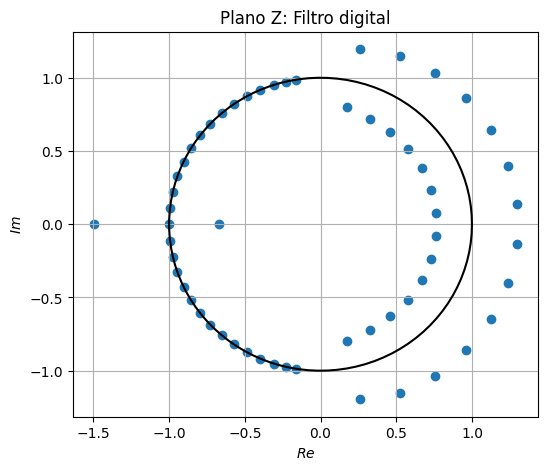

In [36]:
# Plot dos zeros e polos do filtro digital
plot_zeros(zeros)

A distribuição dos zeros ao redor do círculo unitário define a resposta em frequência do filtro. Zeros próximos ao círculo unitário em posições que correspondem a frequências específicas resultarão em forte atenuação nessas frequências.

Zero em 𝑧 = −1 corresponde à frequência 𝜔=𝜋 indicando que essa frequência será eliminada.

A presença de pares complexos conjugados garante que o filtro seja de fase linear, o que significa que todas as frequências sofrerão o mesmo atraso de grupo.

### Plots

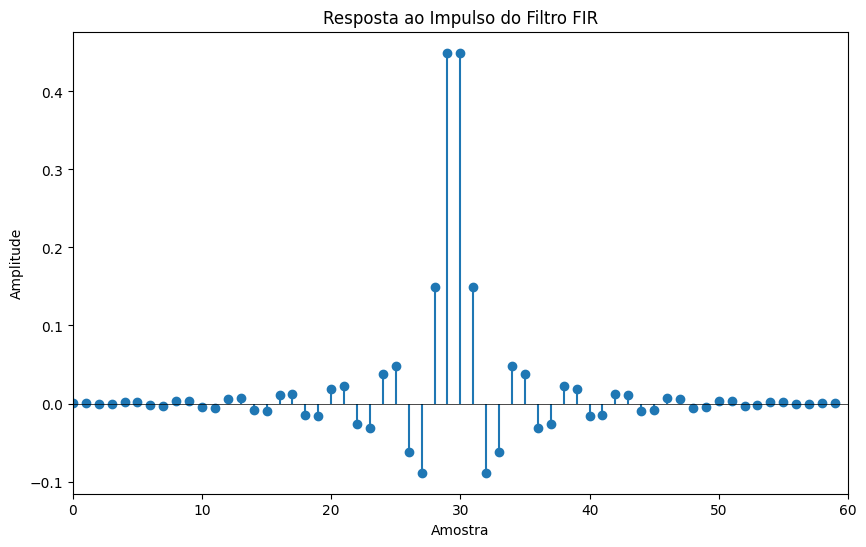

In [37]:
plot_impulse_response(N, filter_h)

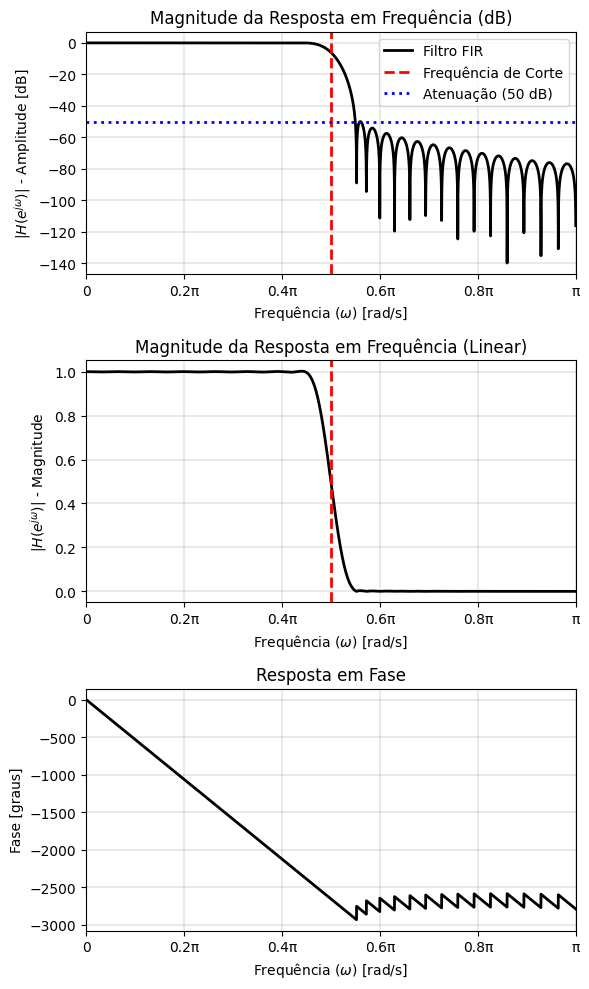

array([<Axes: title={'center': 'Magnitude da Resposta em Frequência (dB)'}, xlabel='Frequência ($\\omega$) [rad/s]', ylabel='$|H(e^{j\\omega})|$ - Amplitude [dB]'>,
       <Axes: title={'center': 'Magnitude da Resposta em Frequência (Linear)'}, xlabel='Frequência ($\\omega$) [rad/s]', ylabel='$|H(e^{j\\omega})|$ - Magnitude'>,
       <Axes: title={'center': 'Resposta em Fase'}, xlabel='Frequência ($\\omega$) [rad/s]', ylabel='Fase [graus]'>],
      dtype=object)

In [38]:
plot_frequency_and_phase_response(w_normalized, h, cutoff, attenuation, return_axs=True)

A resposta ao impulso apresenta a simetria característica de um sistema de Tipo II. 

A resposta em magnitude logarítmica em dB, indica que H(ejω) é zero em ω = π ou, de modo equivalente, que H(z) tem um zero em z = −1, como requerido para um sistema FIR de Tipo II.

Agora vamos definir erro de aproximação nas faixas de passagem e rejeição.

#### Erro de aproximação

O gráfico da magnitude logarítmica em dB indica que $H(e^{j\omega})$ é zero em $\omega = \pi$ ou, de modo equivalente, que $H(z)$ tem um zero em $z = -1$, como requerido para um sistema FIR de Tipo II.

Podemos plotar o erro de aproximação nas faixas de passagem e rejeição. Essa função de erro é definida como:

$$
E_A(\omega) =
\begin{cases} 
1 - A_e(e^{j\omega}), & 0 \leq \omega \leq \omega_p \\
0 - A_e(e^{j\omega}), & \omega_s \leq \omega \leq \pi 
\end{cases}
$$


Onde:
- $A_e(e^{j\omega})$ é a magnitude da resposta em frequência do filtro projetado.
- $\omega_p$ é a frequência de passagem.
- $\omega_s$ é a frequência de rejeição.

O erro $E_A(\omega)$ não é definido na região de transição entre $\omega_p$ e $\omega_s$.

Essa função de erro $E_A(\omega)$ quantifica a diferença entre a resposta ideal e a resposta obtida em diferentes bandas, sendo uma medida crucial da precisão do filtro projetado.

In [39]:
# Função para calcular o erro de aproximação
def approximation_error(w, h, wp, ws):
    # Inicializa o erro como NaN (indefinido na região de transição)
    error = np.full_like(w, np.nan)

    # Calcula o erro na faixa de passagem: 0 ≤ ω ≤ ωp
    error[w <= wp] = 1 - np.abs(h[w <= wp])

    # Calcula o erro na faixa de rejeição: ωs ≤ ω ≤ π
    error[w >= ws] = 0 - np.abs(h[w >= ws])

    return error

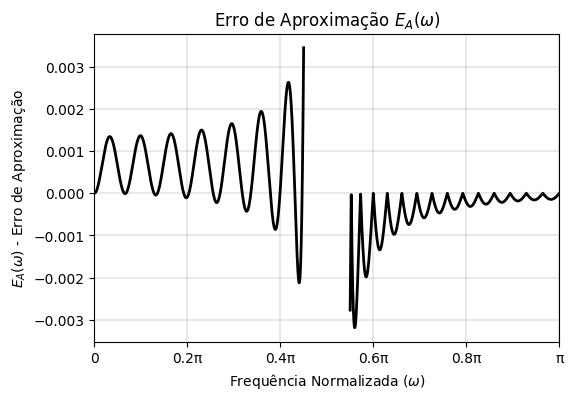

In [40]:
error = approximation_error(w_normalized, h, wp, ws)
plot_approximation_error(w_normalized, error)

O erro foi considerado satisfatório para nosso projeto. Para reduzir o mesmo, teríamos que aumentar a magnitude de atenuação $A$ ou reduzir a faixa de transição $\Delta \omega$, causando num aumento do $M$.

#### Atraso de grupo \( $\tau_g(\omega)$ \) em Filtros FIR

O **atraso de grupo** é uma medida do tempo que um sinal de uma determinada frequência \( $\omega$ \) é atrasado ao passar por um filtro. Para um filtro FIR simétrico com fase linear, o atraso de grupo é constante e igual a \( M/2 \), onde \( M \) é a ordem do filtro.

#### Por que o atraso de grupo é \( M/2 \)?

- **Fase Linear**: Um filtro FIR com fase linear tem uma resposta em fase \( \phi(\omega) = -\omega \cdot \tau_g \). O atraso de grupo \( \tau_g(\omega) \), dado por \( \tau_g(\omega) = -\frac{d\phi(\omega)}{d\omega} \), é constante e igual a \( M/2 \).
  
- **Centralização da Resposta ao Impulso**: Em um filtro FIR simétrico, a resposta ao impulso é centrada no meio do filtro, resultando em um atraso de grupo médio de \( M/2 \) amostras.

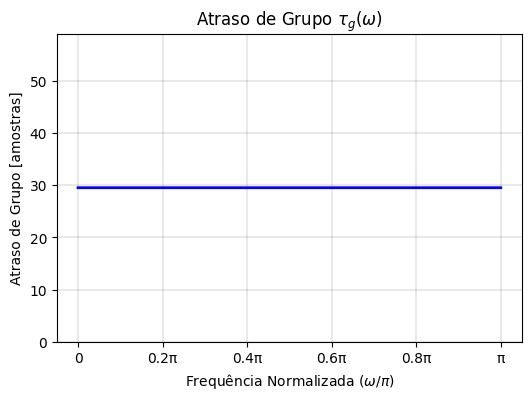

In [41]:
def plot_group_delay(M, w):
    # Atraso de grupo constante para um filtro FIR simétrico
    tau_g = M / 2 * np.ones_like(w)

    plt.figure(figsize=(6, 4))
    plt.plot(w, tau_g, color="blue", linewidth=2.0)
    plt.title('Atraso de Grupo $\\tau_g(\\omega)$')
    plt.xlabel(r'Frequência Normalizada ($\omega/\pi$)')
    plt.ylabel('Atraso de Grupo [amostras]')
    plt.ylim([0, M])
    plt.grid(True, which='both', linestyle='-', linewidth=0.2, alpha=0.6, color='black')
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], 
               ['0', '0.2π', '0.4π', '0.6π', '0.8π', 'π'])
    plt.show()

plot_group_delay(M, w/pi)

### Filtro feito com menos funções auxiliares com o mesmo resultado

In [42]:
# Definir parâmetros do filtro
As = 50  # Atenuação mínima na banda de rejeição (dB)
delta_w = 0.1 * pi  # Largura de transição

# Calcular o parâmetro beta_kaiser da janela de Kaiser
beta_kaiser = 0
if As > 50:
    beta_kaiser = 0.1102 * (As - 8.7)
elif As >= 21:
    beta_kaiser = 0.5842 * (As - 21)**0.4 + 0.07886 * (As - 21)

# Calcular o comprimento do filtro
N_kaiser = int(np.ceil((As - 8) / (2.285 * delta_w))) + 1

# Gerar a resposta ao impulso do filtro ideal (sinc function)
n_kaiser = np.arange(N_kaiser)
h_kaiser = np.sinc((n_kaiser - (N_kaiser - 1) / 2) * wc / pi)

# Aplicar a janela de Kaiser
window = kaiser(N_kaiser, beta_kaiser)
h_kaiser = h_kaiser * window

# Normalizar o filtro
h_kaiser /= np.sum(h_kaiser)

w_kaiser, H_kaiser = freqz(h_kaiser, worN=8000)
w_kaiser_normalized = w_kaiser/pi

print(f"M: {N_kaiser - 1}")
print(f"Beta: {beta_kaiser}")

M: 59
Beta: 4.533514120981248


Podemos ver que utilizando as formulas do Openheimer, obtemos o mesmo filtro que utilizando as funções do scipy.

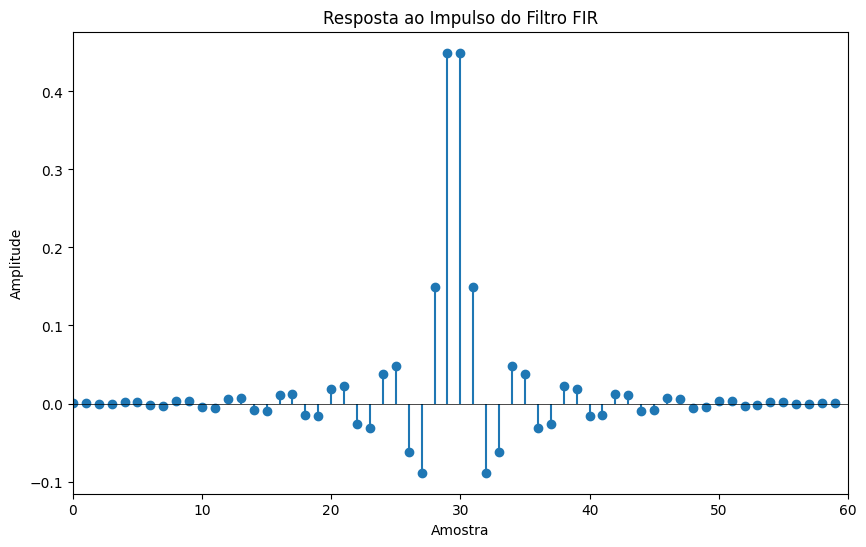

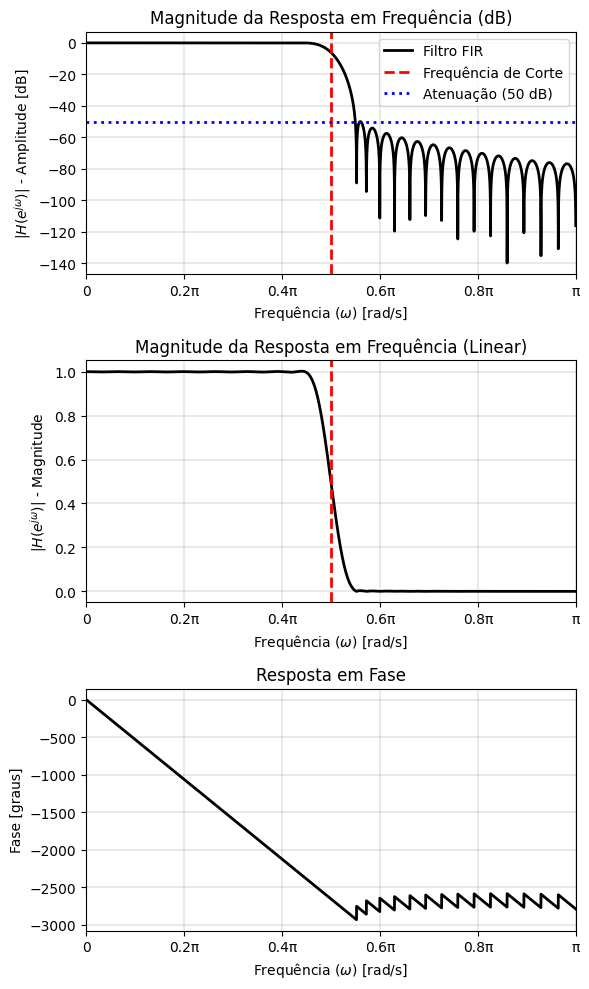

In [43]:
plot_impulse_response(N, h_kaiser)
plot_frequency_and_phase_response(w_normalized, h, cutoff, attenuation)

## Cascata

O formato em cascata, ou forma de seção de segunda ordem (SOS), é uma representação usada para implementar filtros digitais, especialmente filtros IIR (Infinite Impulse Response). A teoria por trás desse formato envolve várias considerações sobre estabilidade, precisão e eficiência computacional.

Filtros de Resposta ao Impulso Finita (FIR) têm um número finito de coeficientes e, portanto, não têm polos (zeros no denominador). A implementação de um filtro FIR geralmente não necessita de uma decomposição em seções de segunda ordem, pois a implementação direta é geralmente estável e simples. Dito isto, vamos avaliar os resultados desta implementação.

Para converter o filtro FIR para a forma em cascata, utilizamos a __tf2sos__ para converter a representação de um filtro em formato de coeficientes de numerador e denominador. Em seguida aplicamos os subfiltros em cascata e plotamos a resposta em frequência.

In [44]:
# O filtro FIR pode ser considerado como um filtro IIR com coeficientes denominadores iguais a 1
a = np.array([1.0])         # Filtros FIR têm a parte denominadora igual a 1
sos = tf2sos(b=filter_h,
             a=a)           # Convertendo para a forma de seções de segundo ordem

# Resposta em frequência para o filtro em cascata
w_cascade, H_cascade = sosfreqz(sos, worN=8000)
w_cascade_normalized = w_cascade / pi

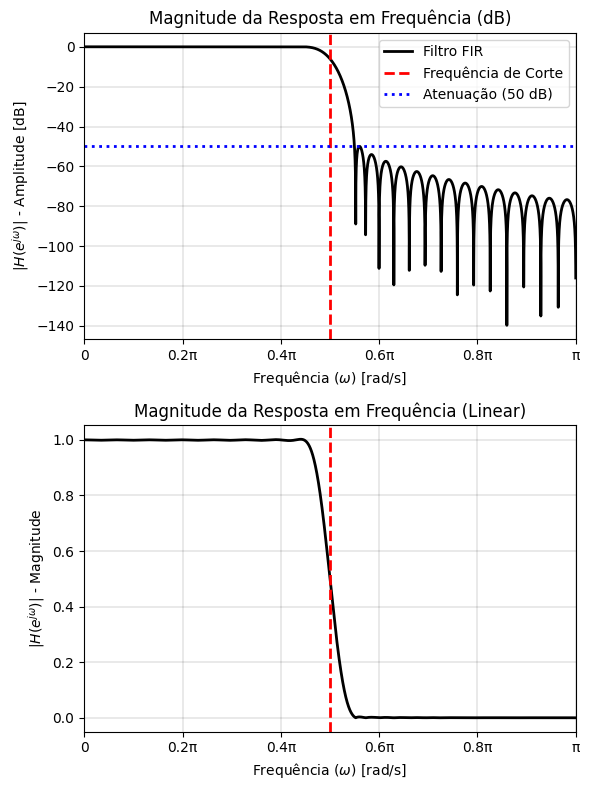

In [45]:
plot_frequency_response(w_cascade_normalized, H_cascade, cutoff, attenuation)

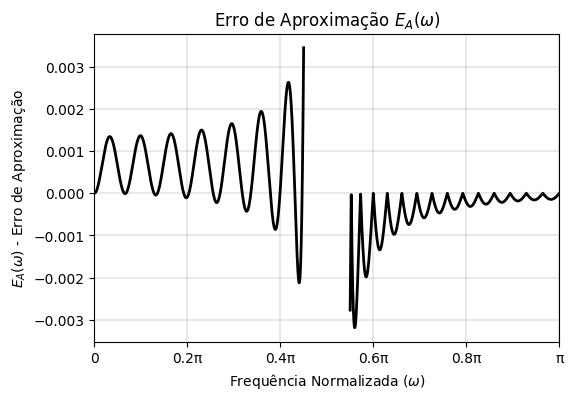

In [46]:
error = approximation_error(w_cascade_normalized, h, wp, ws)
plot_approximation_error(w_cascade_normalized, error)

## Diminuindo o número de casas decimais

In [47]:
# # Função para quantizar coeficientes
# def quantize_coefficients(coefficients, decimal_places):
#     factor = 10 ** decimal_places
#     return np.round(coefficients * factor) / factor

# # Número de casas decimais para quantização
# decimal_places_list = [0, 2, 4, 6]

# # Função para plotar resposta em frequência
# def plot_frequency_response(w, h, title):
#     plt.figure(figsize=(8, 6))
#     plt.plot(w / np.pi, 20 * np.log10(np.abs(h)), label='Resposta em Frequência')
#     plt.title(title)
#     plt.xlabel('Frequência Normalizada ($\omega/\pi$)')
#     plt.ylabel('Magnitude (dB)')
#     plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#     plt.legend(loc='best')
#     plt.show()

# # Plotar resposta em frequência para diferentes quantizações
# for decimal_places in decimal_places_list:
#     # Quantizar coeficientes
#     b_quantized = quantize_coefficients(filter_h, decimal_places)
#     sos_quantized = tf2sos(b_quantized, a)
    
#     # Resposta em frequência quantizada
#     w_q, h_q = freqz(b=b_quantized, worN=8000)
#     w_sos_q, h_sos_q = sosfreqz(sos_quantized, worN=8000)
    
#     # Plotar para a forma direta
#     plot_frequency_response(w_q, h_q, f'Resposta em Frequência (Direta) - Quantização em {decimal_places} casas decimais')
    
#     # Plotar para a forma SOS
#     plot_frequency_response(w_sos_q, h_sos_q, f'Resposta em Frequência (SOS) - Quantização em {decimal_places} casas decimais')


In [48]:
# Função para quantizar coeficientes
def quantize_coefficients(coefficients, decimals):
    return np.round(coefficients, decimals)

# Níveis de quantização a serem testados
quantization_levels = [6, 5, 4, 3, 2, 1]

### Forma direta

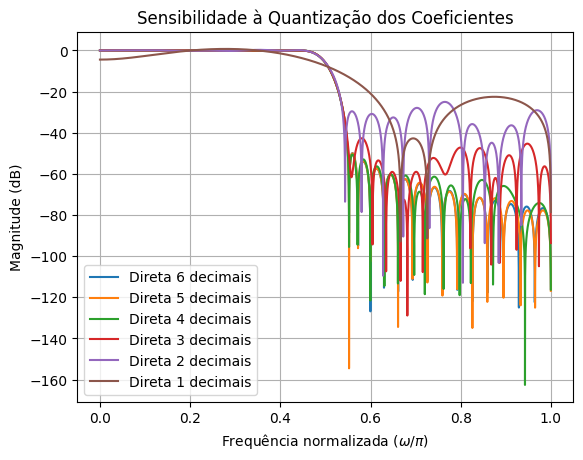

In [49]:
for decimals in quantization_levels:
    h_quantized = quantize_coefficients(filter_h, decimals)
    
    # Resposta em frequência da forma direta (FIR quantizado)
    w_direct, H_direct = signal.freqz(h_quantized, worN=8000)
    
    plt.plot(w_direct / pi, 20 * np.log10(np.abs(H_direct)), label=f'Direta {decimals} decimais')

# Configurações do gráfico
plt.xlabel('Frequência normalizada ($\omega/\pi$)')
plt.ylabel('Magnitude (dB)')
plt.title('Sensibilidade à Quantização dos Coeficientes')
plt.legend()
plt.grid(True)
plt.show()


### Forma em cascata

d:\Code\Projetos\FIR_Filter_WindowMethod\.venv\Lib\site-packages\scipy\signal\_filter_design.py:1112: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)


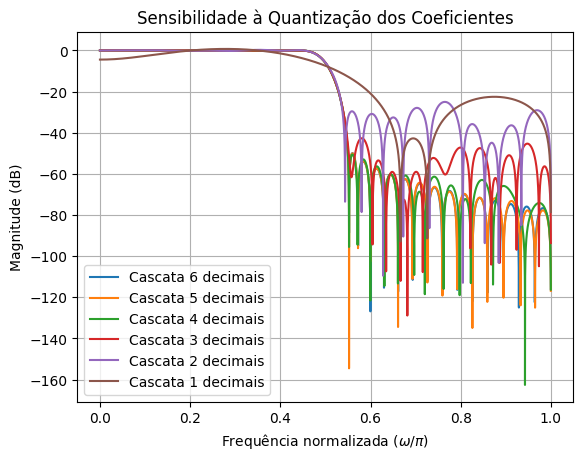

In [50]:
for decimals in quantization_levels:
    h_quantized = quantize_coefficients(filter_h, decimals)
    
    # Convertendo para a forma de seções de segunda ordem (cascata)
    sos_quantized = signal.tf2sos(h_quantized, [1.0])
    
    # Resposta em frequência da forma em cascata (FIR quantizado)
    w_cascade, H_cascade = signal.sosfreqz(sos_quantized, worN=8000)
    
    plt.plot(w_cascade / pi, 20 * np.log10(np.abs(H_cascade)), linestyle='-', label=f'Cascata {decimals} decimais')

# Configurações do gráfico
plt.xlabel('Frequência normalizada ($\omega/\pi$)')
plt.ylabel('Magnitude (dB)')
plt.title('Sensibilidade à Quantização dos Coeficientes')
plt.legend()
plt.grid(True)
plt.show()

## Tranformações em frequência

Transformações em frequência são usadas para obter, a partir de uma função de transferência passa-baixas, filtros passa-altas, passa-banda, rejeita-faixa, ou passa-baixas com diferente faixa de passagem $𝐻(𝑧)$

| Tipo de Filtro  | Transformações | Fórmulas de Projeto Associadas |
|-----------------|-----------------|--------------------------------|
| Passa-baixas    | $Z^{-1} = \frac{z^{-1} - \alpha}{1 - a z^{-1}}$ | $\alpha = \frac{\sin \left(\frac{\theta_p - \omega_p}{2}\right)}{\sin \left(\frac{\theta_p + \omega_p}{2}\right)}$ <br>  |
| Passa-altas     | $Z^{-1} = \frac{- z^{-1} + \alpha}{1 + \alpha z^{-1}}$ | $\alpha = -\frac{\cos \left(\frac{\theta_p + \omega_p}{2}\right)}{\cos \left(\frac{\theta_p - \omega_p}{2}\right)}$ <br>  |
| Passa-faixa     | $Z^{-1} = \frac{- z^{-2} - 2\alpha_k z^{-1} + k}{k + 1} \frac{z^{-1}}{k + 1} + \frac{k - 1}{k + 1} z^{-2} - 2\alpha_k \frac{z^{-1}}{k + 1} + 1$ | $\alpha = \frac{\cos \left(\frac{\omega_{p2} + \omega_{p1}}{2}\right)}{\cos \left(\frac{\omega_{p2} - \omega_{p1}}{2}\right)}$ <br> $k = \cot \left(\frac{\omega_{p2} - \omega_{p1}}{2}\right) \cdot \tan \left(\frac{\theta_p}{2}\right)$ <br>  <br> |
| Rejeita-faixa   | $Z^{-1} = \frac{z^{-2} - 2\alpha}{1 + k z^{-1}} + \frac{1 - k}{1 + k} \frac{1 - k z^{-2}}{1 + k z^{-1}}$ | $\alpha = \frac{\cos \left(\frac{\omega_{p2} + \omega_{p1}}{2}\right)}{\cos \left(\frac{\omega_{p2} - \omega_{p1}}{2}\right)}$ <br> $k = \tan \left(\frac{\omega_{p2} - \omega_{p1}}{2}\right) \cdot \tan \left(\frac{\theta_p}{2}\right)$ <br>  <br> |


- $θ_p$: frequência de *cutoff* do filtro original;
- $\omega_{p1} = \text{frequência de corte inferior desejada}$
- $\omega_{p2} = \text{frequência de corte superior desejada}$ 
- $\omega_p = \text{frequência de corte desejada}$

### $Z^{-1} = -z^{-1}$

Vamos obter um filtro passa-altas a partir do passa-baixas, utilizando a tabela acima com $\alpha = 0$.

A transformação altera o sinal dos coeficientes do filtro. Isso inverte a fase do filtro sem modificar a magnitude da resposta em frequência. Para implementar essa transformação, multiplicamos cada coeficiente do filtro por $-1$ se o índice for par.


In [51]:
filter_h_neg = filter_h * (-1) ** np.arange(len(filter_h))
w_transformed, h_transformed = freqz(filter_h_neg, worN=8000)

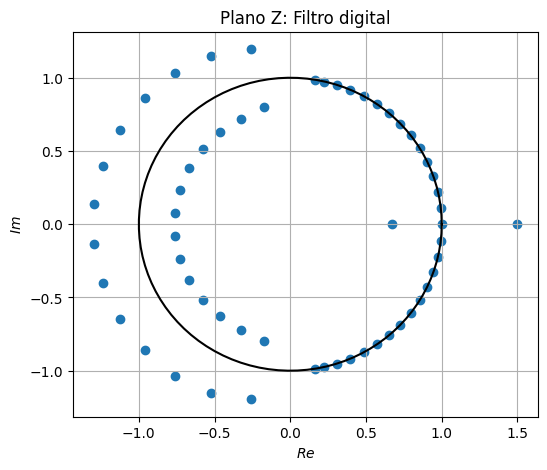

In [52]:
zeros = np.roots(filter_h_neg)

plot_zeros(zeros)

d:\Code\Projetos\FIR_Filter_WindowMethod\notebook\utils.py:41: RuntimeWarning: divide by zero encountered in log10
  axs[0].plot(w, 20 * np.log10(np.abs(h)), color=color, linewidth=2.0, linestyle='-', label="Filtro FIR")


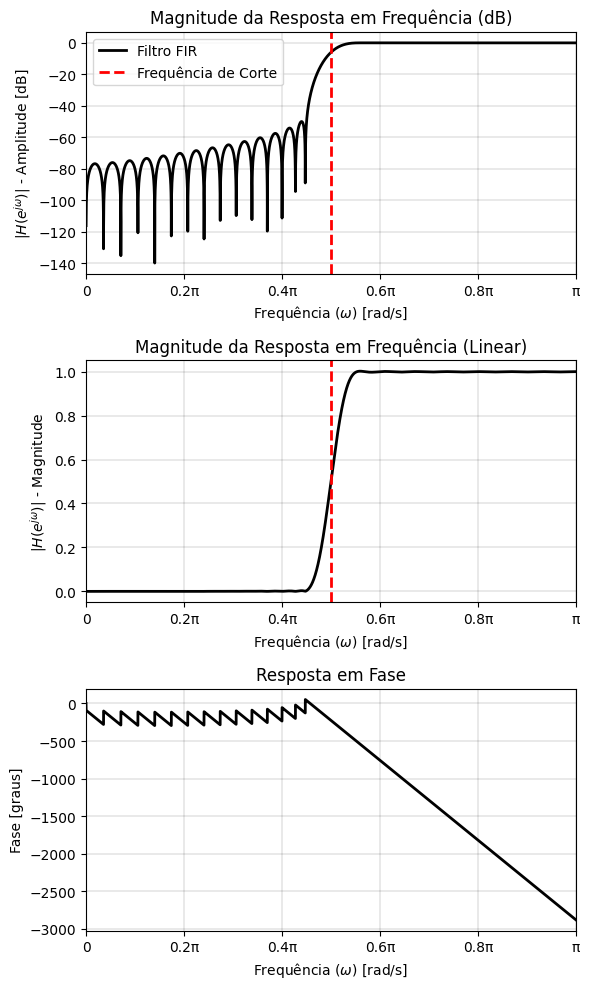

Text(0.5, 1.0, 'Filtro com Transformação Z^(-1) para -Z^(-1)')

In [53]:
axs = plot_frequency_and_phase_response(w_transformed/np.pi, h_transformed, wc=1-cutoff, return_axs=True)
axs[0].set_title("Filtro com Transformação Z^(-1) para -Z^(-1)")

### $Z^{-1} = z^{-2}$

Vamos obter um filtro rejeita-faixas a partir de um passa-baixas, utilizando a tabela acima quando $\alpha = 0$ e $k = 1$.

**Filtro Original**: :

$
H(Z) = h_0 + h_1 Z^{-1} + h_2 Z^{-2} + \dots + h_N Z^{-N}
$

**Transformação**: 

$
H_{\text{novo}}(Z) = h_0 + h_1 Z^{-2} + h_2 Z^{-4} + \dots + h_N Z^{-2N}
$

Ou seja, o novo filtro é obtido simplesmente elevando a ordem de todos os termos \( $Z^{-n}$ \) para \( $Z^{-2n}$ \).

Na implementação, isso significa que você precisa inserir zeros entre cada coeficiente do filtro original. Isso duplicará a largura da transição do filtro e pode alterar as características de frequência. A forma mais direta de implementar isso é construir um novo vetor de coeficientes onde os coeficientes do filtro original são separados por zeros.

In [54]:
filter_h_z2 = np.zeros(2 * len(filter_h))
filter_h_z2[::2] = filter_h

w_z2, h_z2 = freqz(filter_h_z2, worN=8000)

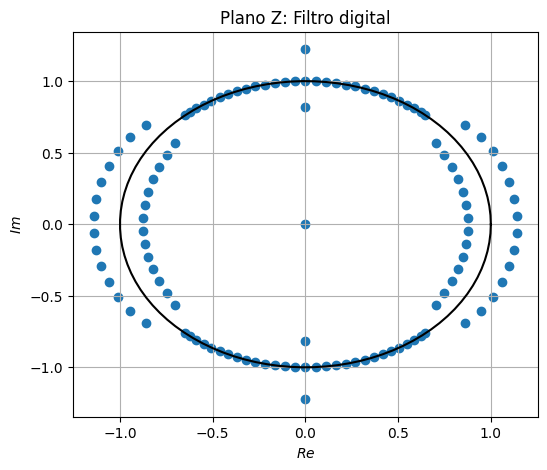

In [56]:
zeros_z2 = np.roots(filter_h_z2)
plot_zeros(zeros_z2)

d:\Code\Projetos\FIR_Filter_WindowMethod\notebook\utils.py:41: RuntimeWarning: divide by zero encountered in log10
  axs[0].plot(w, 20 * np.log10(np.abs(h)), color=color, linewidth=2.0, linestyle='-', label="Filtro FIR")


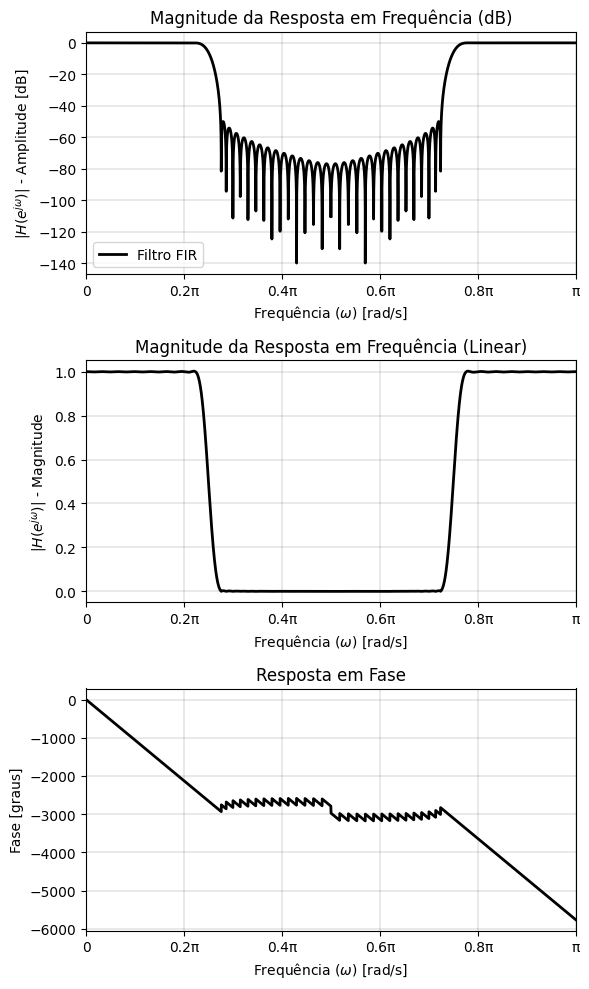

Text(0.5, 1.0, 'Filtro com Transformação Z^(-1) para Z^(-2)')

In [ ]:
axs = plot_frequency_and_phase_response(w_z2 / pi, h_z2, return_axs=True)
axs[0].set_title("Filtro com Transformação Z^(-1) para Z^(-2)")


### $Z^{-1} = -z^{-2}$

Vamos obter um filtro passa-faixa a partir de um passa baixas, utilizando a tabela acima quando $\alpha = 0$ e $k = 1$.
Essa transformação pode ser implementada pela aplicação em sequência das duas anteriores.

In [ ]:
filter_h_neg_z2 = np.zeros(2 * len(filter_h))
filter_h_neg_z2[::2] = filter_h * (-1) ** np.arange(len(filter_h))

w_neg_z2, h_neg_z2 = freqz(filter_h_neg_z2, worN=8000)

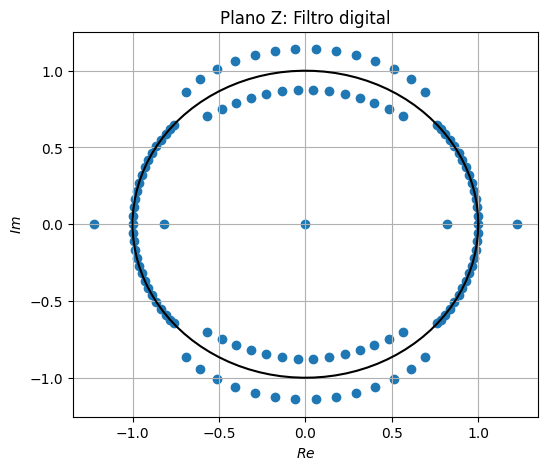

In [57]:
zeros_neg_z2 = np.roots(filter_h_neg_z2)
plot_zeros(zeros_neg_z2)

d:\Code\Projetos\FIR_Filter_WindowMethod\notebook\utils.py:41: RuntimeWarning: divide by zero encountered in log10
  axs[0].plot(w, 20 * np.log10(np.abs(h)), color=color, linewidth=2.0, linestyle='-', label="Filtro FIR")


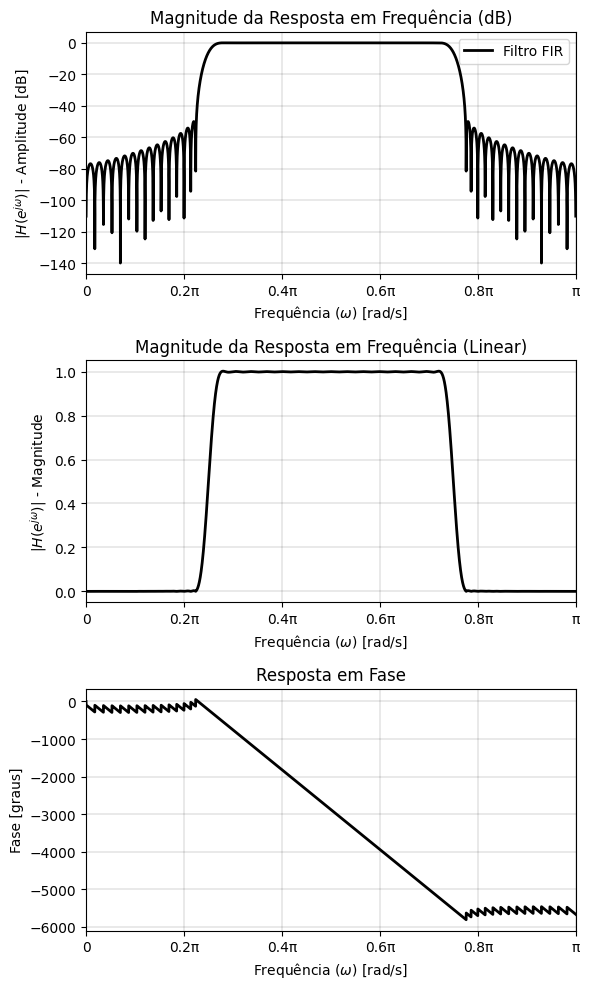

Text(0.5, 1.0, 'Filtro com Transformação Z^(-1) para -Z^(-2)')

In [ ]:
axs = plot_frequency_and_phase_response(w_neg_z2/np.pi, h_neg_z2, return_axs=True)
axs[0].set_title("Filtro com Transformação Z^(-1) para -Z^(-2)")

# Conclusão

![Oppenheim](oppenheim.jpg)
